In [2]:
from utilities import *

I am in libs


In [33]:
%store -r x_scaled
%store -r Y

In [7]:
y_target = Y 
y_target.columns

Index(['mortalité dans le premier séjour réanimation', 'mortalité à J30',
       'mortalité à 90j', 'mortalité à un an', 'target'],
      dtype='object')

# Using death one year after pulmonary analysis

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled,Y,
                                test_size = 0.2, random_state = 7, stratify=Y['mortalité à un an'])

# Machine on the complete dataset without any dimensionality reduction and no tda 

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.79      0.87      0.82        38
           1       0.44      0.31      0.36        13

    accuracy                           0.73        51
   macro avg       0.62      0.59      0.59        51
weighted avg       0.70      0.73      0.71        51

Test Accuracy: 72.55%


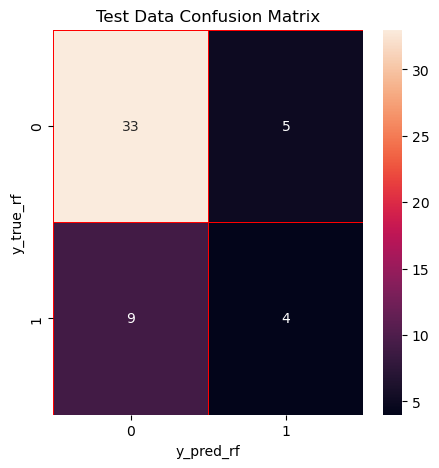

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        38
           1       0.86      0.46      0.60        13

    accuracy                           0.84        51
   macro avg       0.85      0.72      0.75        51
weighted avg       0.85      0.84      0.83        51

Test Accuracy: 84.31%


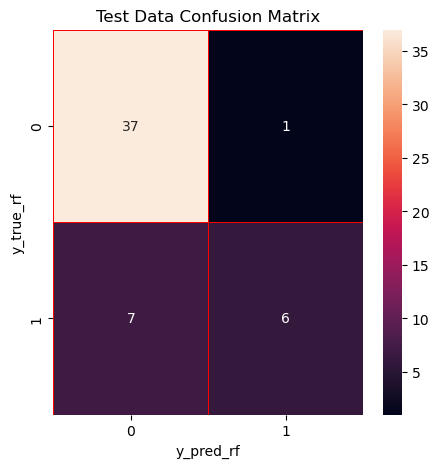

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        38
           1       0.80      0.31      0.44        13

    accuracy                           0.80        51
   macro avg       0.80      0.64      0.66        51
weighted avg       0.80      0.80      0.77        51

Test Accuracy: 80.39%


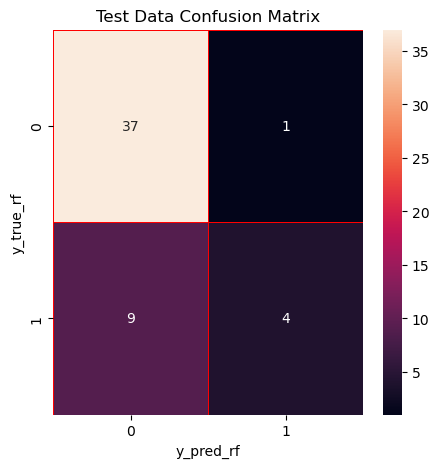

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        38
           1       0.57      0.62      0.59        13

    accuracy                           0.78        51
   macro avg       0.72      0.73      0.72        51
weighted avg       0.79      0.78      0.79        51

Test Accuracy: 78.43%


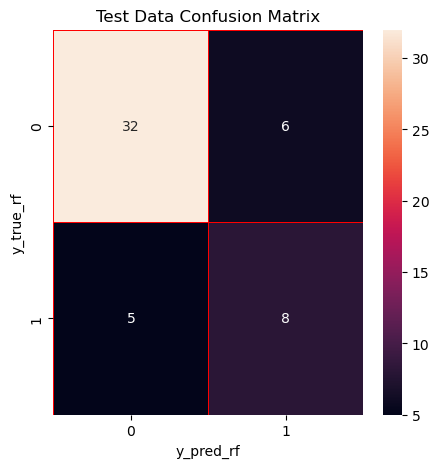

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        38
           1       0.53      0.62      0.57        13

    accuracy                           0.76        51
   macro avg       0.70      0.72      0.70        51
weighted avg       0.78      0.76      0.77        51

Test Accuracy: 76.47%


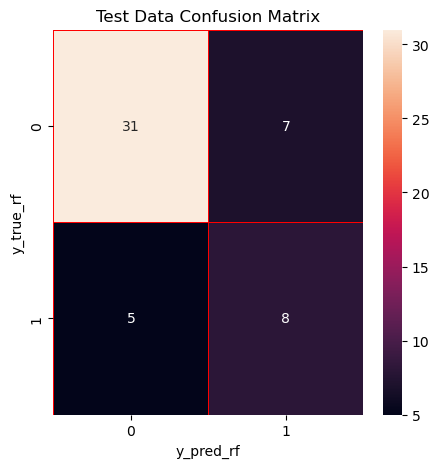

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        38
           1       0.39      0.54      0.45        13

    accuracy                           0.67        51
   macro avg       0.60      0.62      0.61        51
weighted avg       0.71      0.67      0.68        51

Test Accuracy: 66.67%


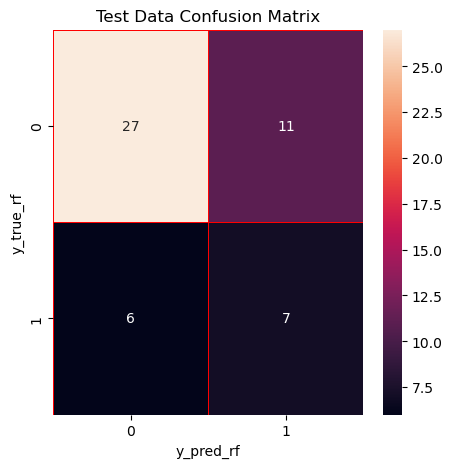

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        38
           1       0.50      0.46      0.48        13

    accuracy                           0.75        51
   macro avg       0.66      0.65      0.66        51
weighted avg       0.74      0.75      0.74        51

Test Accuracy: 74.51%


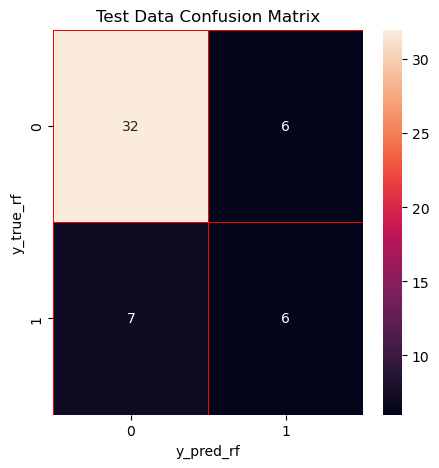

,LogisticRegression,KNeighborsClassifier,SVC,MLPClassifier,GaussianNB,DecisionTreeClassifier,RandomForestClassifier
0,0.7255,0.8431,0.8039,0.7843,0.7647,0.6667,0.7451


In [10]:
showResult(classifiers,x_train,y_train["mortalité à un an"],test=[x_test,y_test["mortalité à un an"]])

In [10]:
dataset=[(x,y) for x,y in zip(x_train.to_numpy(),y_train['mortalité à un an'])]
data_set=[(x,y) for x,y in zip(x_test.to_numpy(),y_test['mortalité à un an'])]

train_loader=DataLoader(dataset, batch_size=3, shuffle=True)
test_loader=DataLoader(data_set,batch_size=1,shuffle=True)

In [11]:
test_loader=DataLoader(data_set,batch_size=3,shuffle=True)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
persistence = VietorisRipsPersistence(metric = 'euclidean',homology_dimensions=[0,1,2],n_jobs=-1,collapse_edges=True)

In [14]:
PE = PersistenceEntropy()

In [15]:
x_train.shape

(201, 40)

In [16]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(40, 2)

        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 40)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = model().to(device)
model=model.double()
learning_rate = 0.001

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)
mse=nn.MSELoss()

In [17]:
from gtda.diagrams import Amplitude
import sklearn

losses=[]

num_epochs=150

batch_size = len(train_loader)

for epoch in range(num_epochs):

    X=[]
    Y=[]

    total_loss = 0

    for data in train_loader:

        x,y=data

        output = model(x)
        e=model.encoder(x).detach().numpy()

        X.append(e)
        Y.append(y.numpy())


        dy=persistence.fit_transform(output.detach().numpy()[None,:,:])
        dz=persistence.fit_transform(e[None,:,:])
        dx=persistence.fit_transform(x[None,:,:])

        a1=Amplitude(metric='bottleneck').fit_transform(dx)
        a2=Amplitude(metric='wasserstein').fit_transform(dx)
        a3=Amplitude(metric='landscape').fit_transform(dx)
        a4=Amplitude(metric='betti').fit_transform(dx)
        a5=Amplitude(metric='persistence_image').fit_transform(dx)

        a=a1+a2+a3+a4+a5

        b1=Amplitude(metric='bottleneck').fit_transform(dz)
        b2=Amplitude(metric='wasserstein').fit_transform(dz)
        b3=Amplitude(metric='landscape').fit_transform(dz)
        b4=Amplitude(metric='betti').fit_transform(dz)
        b5=Amplitude(metric='persistence_image').fit_transform(dz)

        b=b1+b2+b3+b4+b5

        c1=Amplitude(metric='bottleneck').fit_transform(dy)
        c2=Amplitude(metric='wasserstein').fit_transform(dy)
        c3=Amplitude(metric='landscape').fit_transform(dy)
        c4=Amplitude(metric='betti').fit_transform(dy)
        c5=Amplitude(metric='persistence_image').fit_transform(dy)

        c=c1+c2+c3+c4+c5


        l1=(np.linalg.norm(a-b)**2)/2

        l2=(np.linalg.norm(b-c)**2)/2

        l=l1+l2


        loss = mse(output, x)+(1e-5)*l

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.data
    total_loss = total_loss / batch_size
    losses.append(total_loss)

    Y=np.asarray(Y).reshape(1,-1)
    X=np.asarray(X).reshape(201,2)


    print("epoch : {}/{},  loss = {:.4f}".format(epoch + 1, num_epochs, total_loss))



epoch : 1/150,  loss = 1.2593
epoch : 2/150,  loss = 1.1968
epoch : 3/150,  loss = 1.1505
epoch : 4/150,  loss = 1.1104
epoch : 5/150,  loss = 1.0754
epoch : 6/150,  loss = 1.0450
epoch : 7/150,  loss = 1.0177
epoch : 8/150,  loss = 0.9946
epoch : 9/150,  loss = 0.9730
epoch : 10/150,  loss = 0.9533
epoch : 11/150,  loss = 0.9342
epoch : 12/150,  loss = 0.9130
epoch : 13/150,  loss = 0.8920
epoch : 14/150,  loss = 0.8703
epoch : 15/150,  loss = 0.8440
epoch : 16/150,  loss = 0.8147
epoch : 17/150,  loss = 0.7850
epoch : 18/150,  loss = 0.7529
epoch : 19/150,  loss = 0.7203
epoch : 20/150,  loss = 0.6850
epoch : 21/150,  loss = 0.6530
epoch : 22/150,  loss = 0.6201
epoch : 23/150,  loss = 0.5878
epoch : 24/150,  loss = 0.5604
epoch : 25/150,  loss = 0.5336
epoch : 26/150,  loss = 0.5090
epoch : 27/150,  loss = 0.4879
epoch : 28/150,  loss = 0.4692
epoch : 29/150,  loss = 0.4511
epoch : 30/150,  loss = 0.4361
epoch : 31/150,  loss = 0.4234
epoch : 32/150,  loss = 0.4115
epoch : 33/150,  

# Visualization of loss function

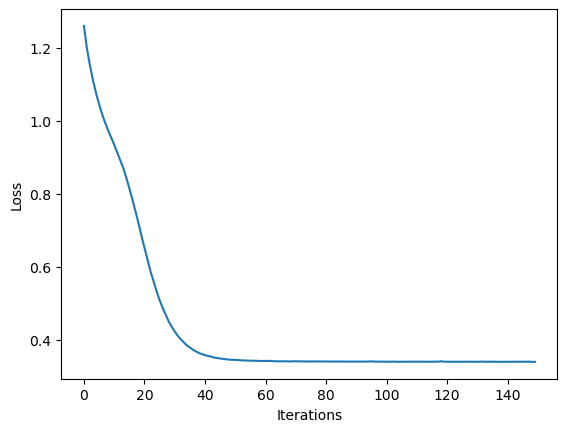

In [18]:
plt.plot(losses[:])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [19]:
x_test.shape

(51, 40)

In [20]:
test_loss = 0
s=0
with torch.no_grad():
    X=[]
    Y=[]

    for data in test_loader:
        x,y=data

        output = model(x)


        e=model.encoder(x).detach().numpy()

        X.append(e)

        Y.append(y.numpy())

        dy=persistence.fit_transform(output.detach().numpy()[None,:,:])
        dz=persistence.fit_transform(e[None,:,:])
        dx=persistence.fit_transform(x[None,:,:])

        a1=Amplitude(metric='bottleneck').fit_transform(dx)
        a2=Amplitude(metric='wasserstein').fit_transform(dx)
        a3=Amplitude(metric='landscape').fit_transform(dx)
        a4=Amplitude(metric='betti').fit_transform(dx)
        a5=Amplitude(metric='persistence_image').fit_transform(dx)

        a=a1+a2+a3+a4+a5

        b1=Amplitude(metric='bottleneck').fit_transform(dz)
        b2=Amplitude(metric='wasserstein').fit_transform(dz)
        b3=Amplitude(metric='landscape').fit_transform(dz)
        b4=Amplitude(metric='betti').fit_transform(dz)
        b5=Amplitude(metric='persistence_image').fit_transform(dz)

        b=b1+b2+b3+b4+b5

        c1=Amplitude(metric='bottleneck').fit_transform(dy)
        c2=Amplitude(metric='wasserstein').fit_transform(dy)
        c3=Amplitude(metric='landscape').fit_transform(dy)
        c4=Amplitude(metric='betti').fit_transform(dy)
        c5=Amplitude(metric='persistence_image').fit_transform(dy)

        c=c1+c2+c3+c4+c5

        l1=(np.linalg.norm(a-b)**2)/2

        l2=(np.linalg.norm(b-c)**2)/2

        l=l1+l2


        loss = mse(output, x)+(1e-3)*l
        test_loss += loss.item()

    test_loss /= len(test_loader)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    #Y=np.asarray(Y).reshape(1,-1)
    #print(np.asarray(X).shape)
    #X=np.asarray(X).reshape(76,6)

    #fig = plt.figure(figsize=(8,8))
    #ax = plt.axes()
    #ax.scatter(X[:,0], X[:,1],c=Y,s=50)
    #ax.set_title('test')

====> Test set loss: 0.9541


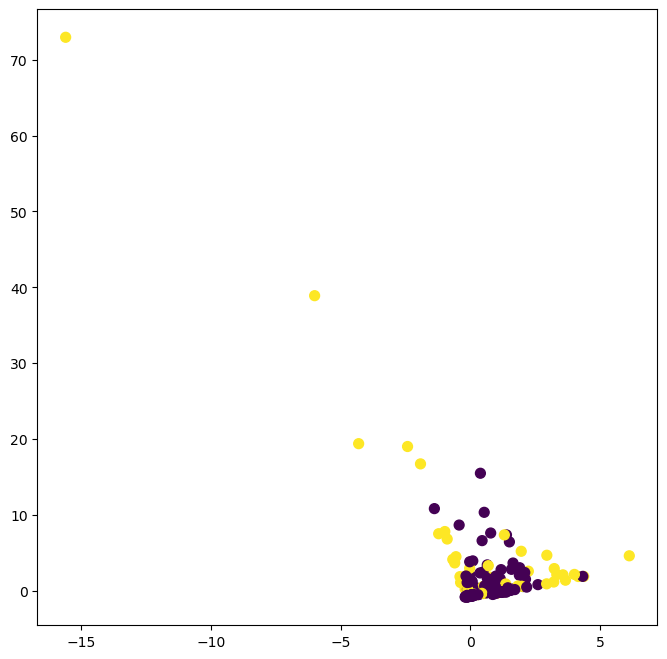

In [28]:
  
m=model.encoder(torch.from_numpy(x_scaled.to_numpy()))
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(m[:,0].detach().numpy(), m[:,1].detach().numpy(),c=y_target["mortalité à un an"].to_numpy(),s=50)

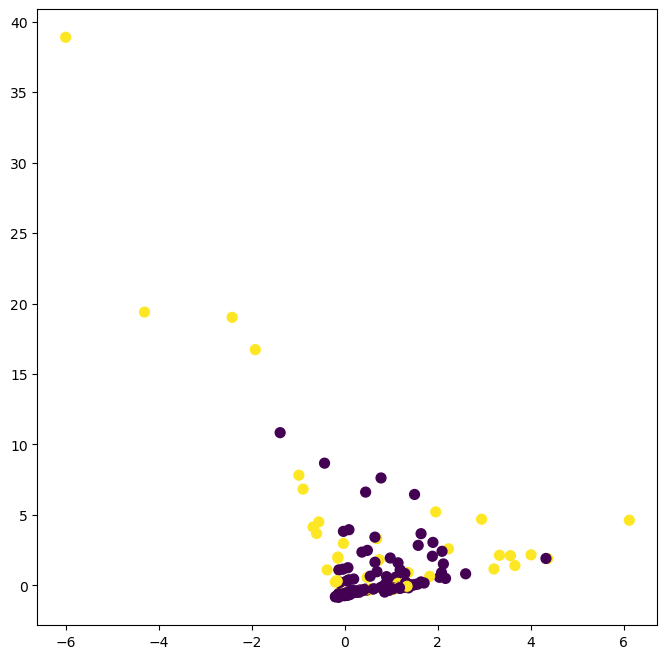

In [29]:
train=model.encoder(torch.from_numpy(x_train.to_numpy()))
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(train[:,0].detach().numpy(), train[:,1].detach().numpy(),c=y_train["mortalité à un an"].to_numpy(),s=50)

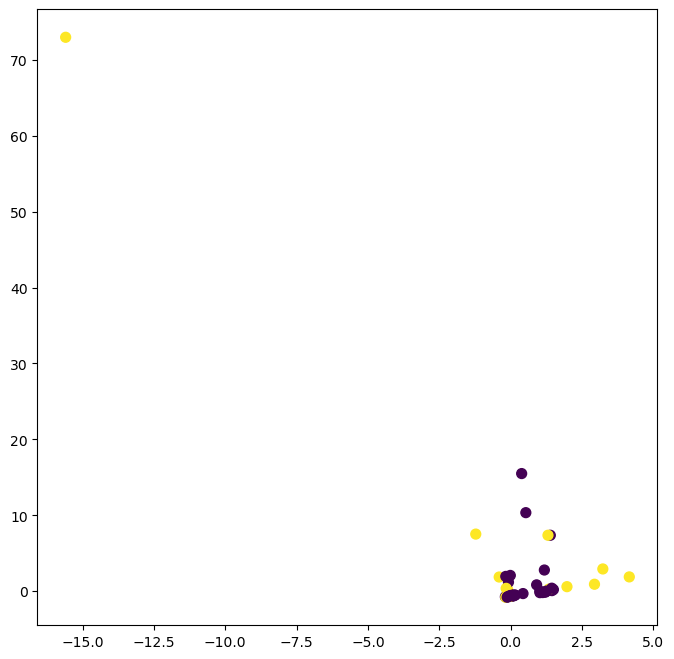

In [30]:
test=model.encoder(torch.from_numpy(x_test.to_numpy()))
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(test[:,0].detach().numpy(), test[:,1].detach().numpy(),c=y_test["mortalité à un an"].to_numpy(),s=50)

In [31]:
%store train
%store test
%store y_train
%store y_test


Stored 'train' (Tensor)
Stored 'test' (Tensor)
Stored 'y_train' (DataFrame)
Stored 'y_test' (DataFrame)


# No need to run the above every time

In [143]:
%store -r train
%store -r test
%store -r y_train
%store -r y_test
%store -r Y

In [144]:
train = pd.DataFrame( train.detach().numpy())
test = pd.DataFrame(test.detach().numpy())

In [6]:
# Calculate class weights for the unbalanced dataset
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y["mortalité à un an"]), y=Y["mortalité à un an"])

# Convert class weights to a dictionary format
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Machine on taelcore

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        38
           1       0.62      0.38      0.48        13

    accuracy                           0.78        51
   macro avg       0.72      0.65      0.67        51
weighted avg       0.77      0.78      0.77        51

Test Accuracy: 78.43%


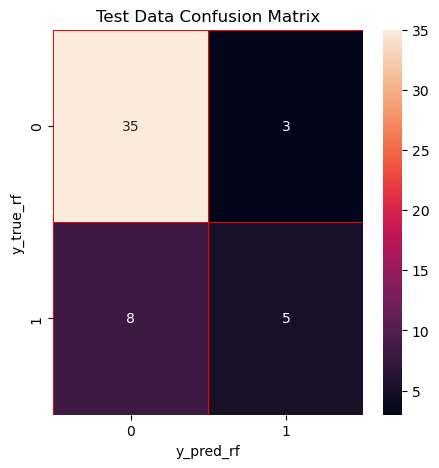

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        38
           1       0.86      0.46      0.60        13

    accuracy                           0.84        51
   macro avg       0.85      0.72      0.75        51
weighted avg       0.85      0.84      0.83        51

Test Accuracy: 84.31%


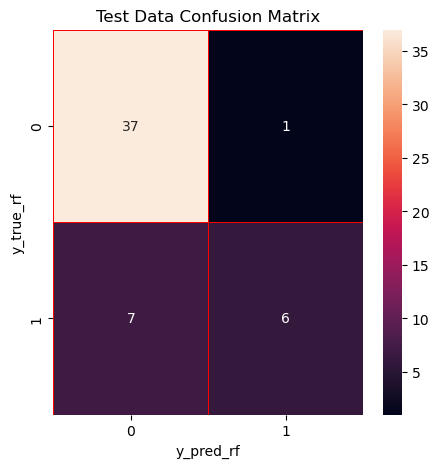

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        38
           1       0.67      0.15      0.25        13

    accuracy                           0.76        51
   macro avg       0.72      0.56      0.56        51
weighted avg       0.74      0.76      0.70        51

Test Accuracy: 76.47%


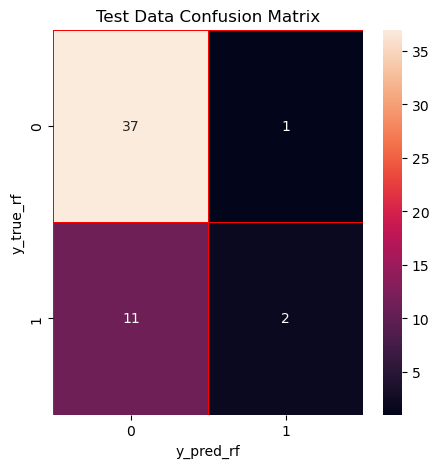

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85        38
           1       0.57      0.31      0.40        13

    accuracy                           0.76        51
   macro avg       0.68      0.61      0.63        51
weighted avg       0.74      0.76      0.74        51

Test Accuracy: 76.47%


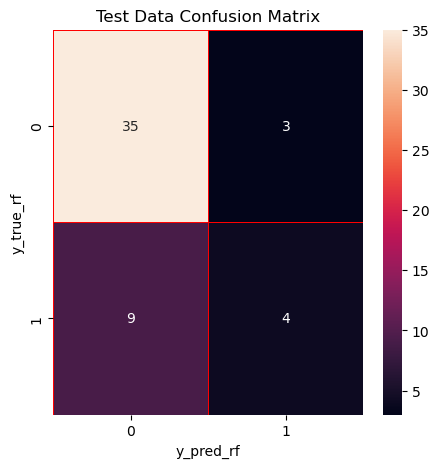

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        38
           1       0.67      0.46      0.55        13

    accuracy                           0.80        51
   macro avg       0.75      0.69      0.71        51
weighted avg       0.79      0.80      0.79        51

Test Accuracy: 80.39%


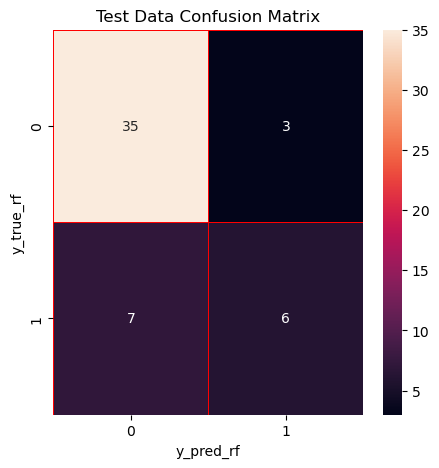

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        38
           1       0.89      0.62      0.73        13

    accuracy                           0.88        51
   macro avg       0.88      0.79      0.83        51
weighted avg       0.88      0.88      0.87        51

Test Accuracy: 88.24%


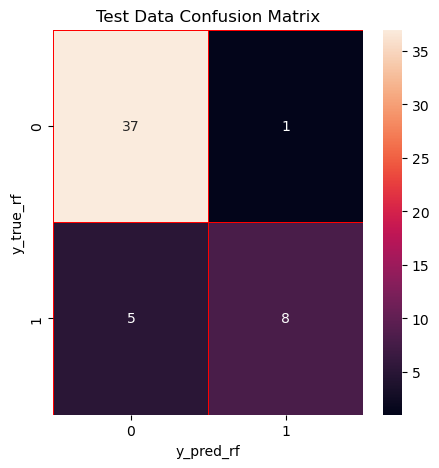

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        38
           1       0.88      0.54      0.67        13

    accuracy                           0.86        51
   macro avg       0.87      0.76      0.79        51
weighted avg       0.86      0.86      0.85        51

Test Accuracy: 86.27%


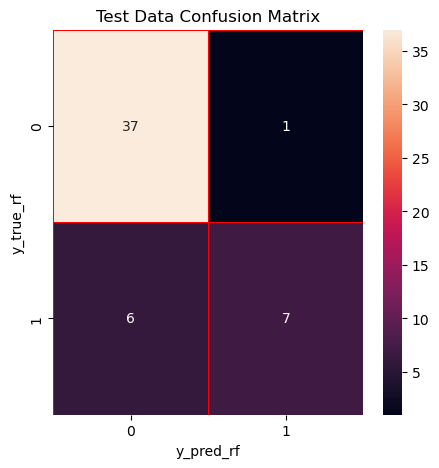

,LogisticRegression,KNeighborsClassifier,SVC,MLPClassifier,GaussianNB,DecisionTreeClassifier,RandomForestClassifier
0,0.7843,0.8431,0.7647,0.7647,0.8039,0.8824,0.8627


In [30]:
showResult(classifiers,train,y_train["mortalité à un an"],test=[test,y_test["mortalité à un an"]])

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        38
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.20      0.20      0.20         5

    accuracy                           0.71        51
   macro avg       0.24      0.28      0.26        51
weighted avg       0.60      0.71      0.65        51

Test Accuracy: 70.59%


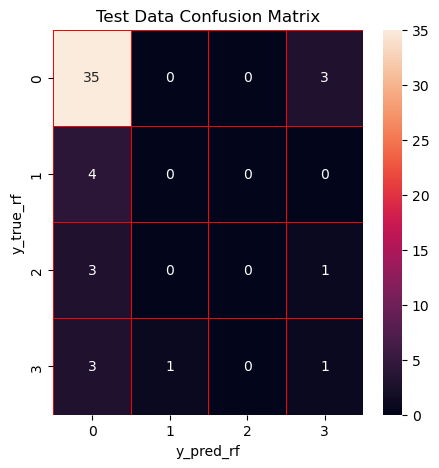

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.83      1.00      0.90        38
           1       0.33      0.25      0.29         4
           2       0.00      0.00      0.00         4
           3       1.00      0.20      0.33         5

    accuracy                           0.78        51
   macro avg       0.54      0.36      0.38        51
weighted avg       0.74      0.78      0.73        51

Test Accuracy: 78.43%


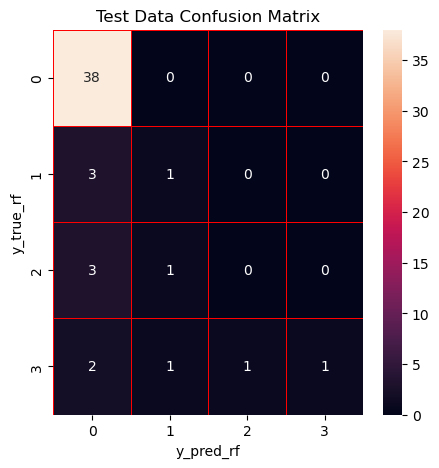

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84        38
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         5

    accuracy                           0.73        51
   macro avg       0.18      0.24      0.21        51
weighted avg       0.55      0.73      0.63        51

Test Accuracy: 72.55%


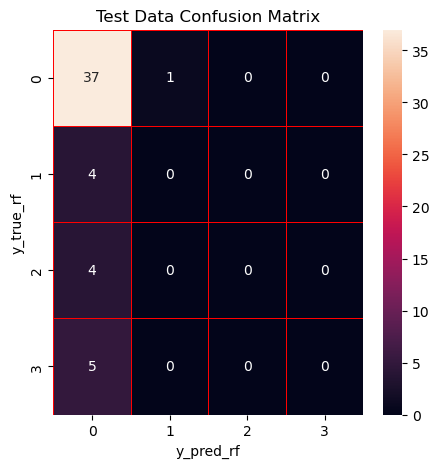

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87        38
           1       0.50      0.25      0.33         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         5

    accuracy                           0.76        51
   macro avg       0.32      0.31      0.30        51
weighted avg       0.62      0.76      0.68        51

Test Accuracy: 76.47%


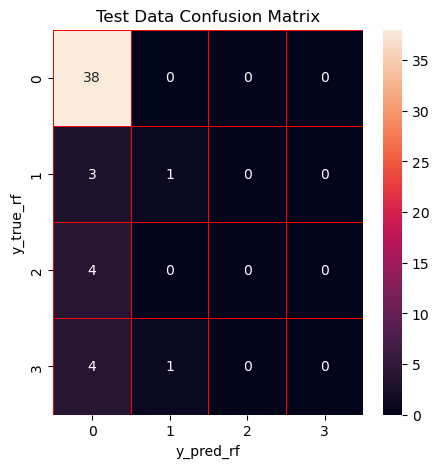

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        38
           1       0.50      0.25      0.33         4
           2       0.50      0.50      0.50         4
           3       0.67      0.40      0.50         5

    accuracy                           0.78        51
   macro avg       0.62      0.52      0.55        51
weighted avg       0.76      0.78      0.77        51

Test Accuracy: 78.43%


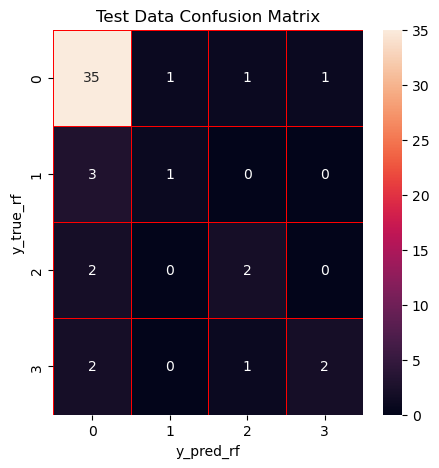

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        38
           1       0.50      0.50      0.50         4
           2       1.00      0.25      0.40         4
           3       0.67      0.40      0.50         5

    accuracy                           0.78        51
   macro avg       0.75      0.52      0.57        51
weighted avg       0.79      0.78      0.76        51

Test Accuracy: 78.43%


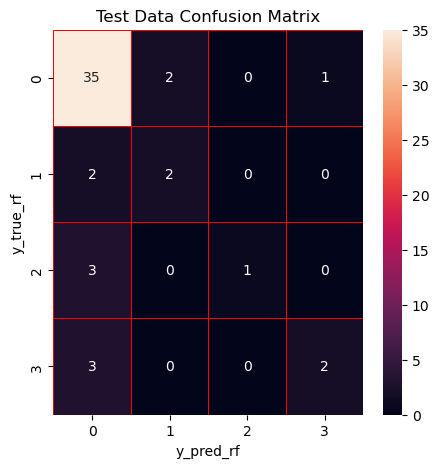

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        38
           1       0.75      0.75      0.75         4
           2       1.00      0.25      0.40         4
           3       1.00      0.60      0.75         5

    accuracy                           0.86        51
   macro avg       0.90      0.64      0.70        51
weighted avg       0.88      0.86      0.84        51

Test Accuracy: 86.27%


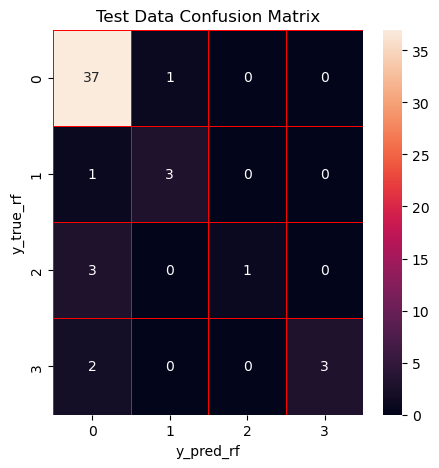

,LogisticRegression,KNeighborsClassifier,SVC,MLPClassifier,GaussianNB,DecisionTreeClassifier,RandomForestClassifier
0,0.7059,0.7843,0.7255,0.7647,0.7843,0.7843,0.8627


In [31]:
showResult(classifiers,train,y_train["target"],test=[test,y_test["target"]])

__________________________________________________
--------------------------------------------------
Results for: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


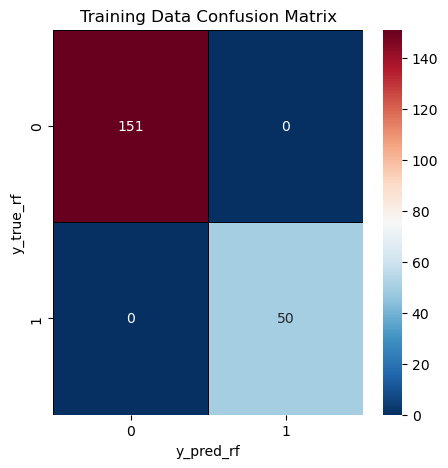

,DecisionTreeClassifier
0,1.0


In [195]:
showResult([DecisionTreeClassifier],train,y_train["mortalité à un an"])

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        38
           1       0.89      0.62      0.73        13

    accuracy                           0.88        51
   macro avg       0.88      0.79      0.83        51
weighted avg       0.88      0.88      0.87        51

Test Accuracy: 88.24%


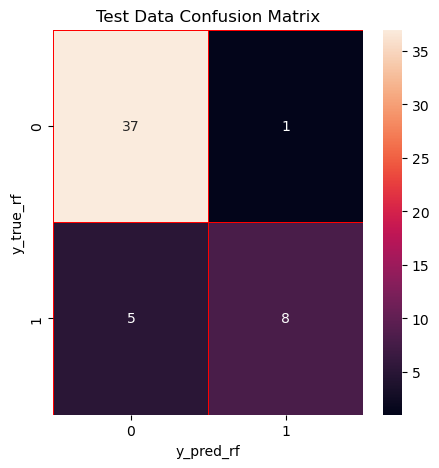

,DecisionTreeClassifier
0,0.8824


In [43]:
showResult([DecisionTreeClassifier],train,y_train["mortalité à un an"],test=[test,y_test["mortalité à un an"]])

We obtain the best results using binary analysis.
The models we are going to ameliorate are: DecisionTreeClassifier, RandomForestClassifier, KNeighborsClassifier,GaussianNB

# DecisionTreeClassifier 

In [17]:
dtc_param = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       min_samples_leaf=2, min_samples_split=10)
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
Best Score: 0.804479445606777
Method
DecisionTreeClassifier
Results for Accuracy Optimized DecisionTreeClassifier GSCV
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       151
           1       0.82      0.56      0.67        50

    accuracy                           0.86       201
   macro avg       0.85      0.76      0.79       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.56


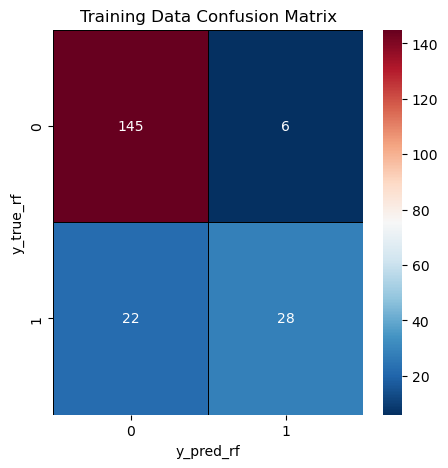

**************************************************
DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       min_samples_leaf=4, min_samples_split=10)
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
Best Score: 0.7167216889146166
Method
DecisionTreeClassifier
Results for Accuracy Optimized DecisionTreeClassifier GSCV
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       151
           1       0.86      0.38      0.53        50

    accuracy                           0.83       201
   macro avg       0.85      0.68      0.71       201
weighted avg       0.84      0.83      0.81       201

Training Accuracy: 0.8308
Training Recall: 0.38


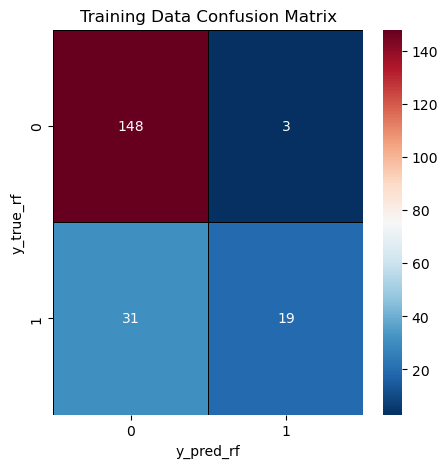

**************************************************
DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=5)
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'best'}
Best Score: 0.8408536585365853
Method
DecisionTreeClassifier
Results for Accuracy Optimized DecisionTreeClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.84      0.52      0.64        50

    accuracy                           0.86       201
   macro avg       0.85      0.74      0.78       201
weighted avg       0.85      0.86      0.84       201

Training Accuracy: 0.8557
Training Recall: 0.52


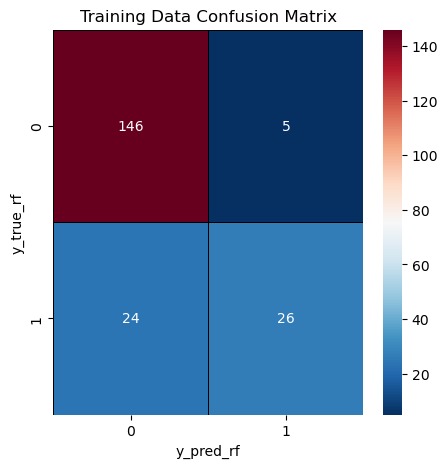

**************************************************
DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10)
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
Best Score: 0.8258536585365854
Method
DecisionTreeClassifier
Results for Accuracy Optimized DecisionTreeClassifier GSCV
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       151
           1       0.89      0.48      0.62        50

    accuracy                           0.86       201
   macro avg       0.87      0.73      0.77       201
weighted avg       0.86      0.86      0.84       201

Training Accuracy: 0.8557
Training Recall: 0.48


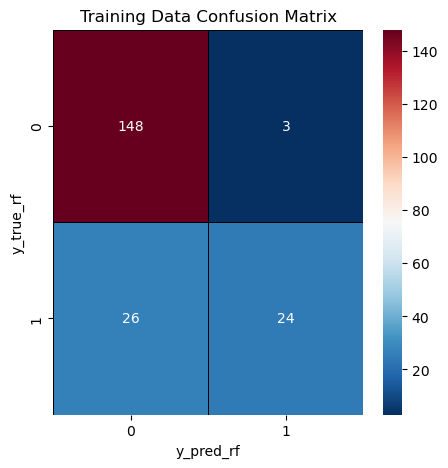

**************************************************
DecisionTreeClassifier(min_samples_split=10)
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Best Score: 0.56
Method
DecisionTreeClassifier
Results for Accuracy Optimized DecisionTreeClassifier GSCV
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.88      0.70      0.78        50

    accuracy                           0.90       201
   macro avg       0.89      0.83      0.86       201
weighted avg       0.90      0.90      0.90       201

Training Accuracy: 0.9005
Training Recall: 0.7


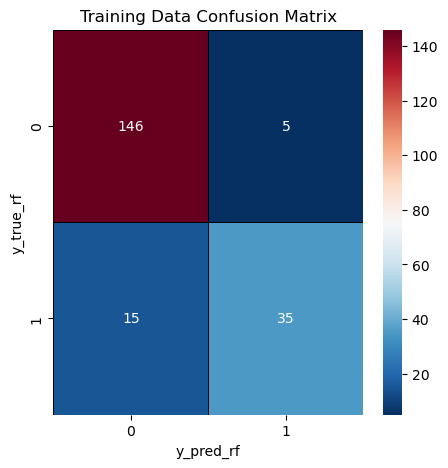

In [18]:
dtc_gscv_weighted,y_pred_weighted=modelTunning(dtc_param,train,y_train["mortalité à un an"],clf,scoring='f1_weighted')
print("*"*50)
dtc_gscv_macro,y_pred_macro=modelTunning(dtc_param,train,y_train["mortalité à un an"],clf,scoring='f1_macro')
print("*"*50)
dtc_gscv_micro,y_pred_micro=modelTunning(dtc_param,train,y_train["mortalité à un an"],clf,scoring='f1_micro')
print("*"*50)
dtc_gscv_accuracy,y_pred_accuracy=modelTunning(dtc_param,train,y_train["mortalité à un an"],clf,scoring='accuracy')
print("*"*50)
dtc_gscv_recall,y_pred_recall=modelTunning(dtc_param,train,y_train["mortalité à un an"],clf,scoring='recall')

The best parameters we are going to use for the analysis is recall because it gives a trainning accuracy of 0.9055 with the following parameters:

DecisionTreeClassifier(min_samples_split=10)
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}

__________________________________________________
--------------------------------------------------
Results for: 0.2
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       151
           1       0.59      0.98      0.74        50

    accuracy                           0.83       201
   macro avg       0.79      0.88      0.80       201
weighted avg       0.89      0.83      0.84       201

Training Accuracy: 0.8259
Training Recall: 0.98


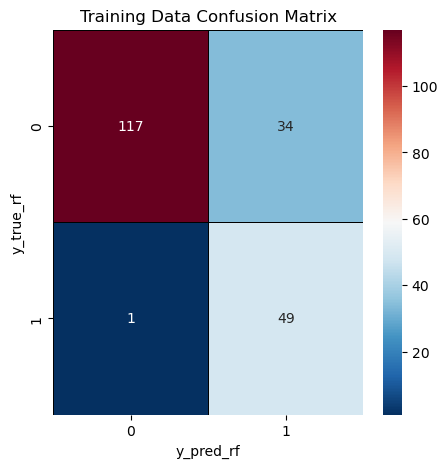

__________________________________________________
--------------------------------------------------
Results for: 0.25
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       151
           1       0.69      0.90      0.78        50

    accuracy                           0.88       201
   macro avg       0.83      0.88      0.85       201
weighted avg       0.90      0.88      0.88       201

Training Accuracy: 0.8756
Training Recall: 0.9


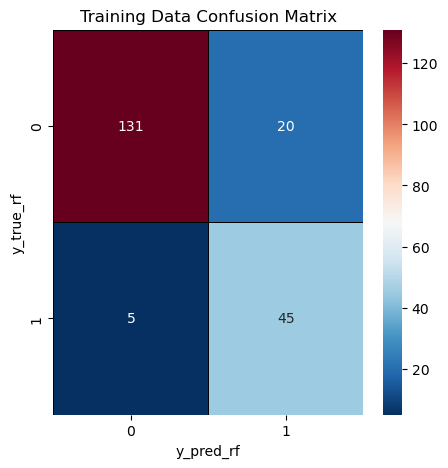

__________________________________________________
--------------------------------------------------
Results for: 0.3
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       151
           1       0.72      0.88      0.79        50

    accuracy                           0.89       201
   macro avg       0.84      0.88      0.86       201
weighted avg       0.90      0.89      0.89       201

Training Accuracy: 0.8856
Training Recall: 0.88


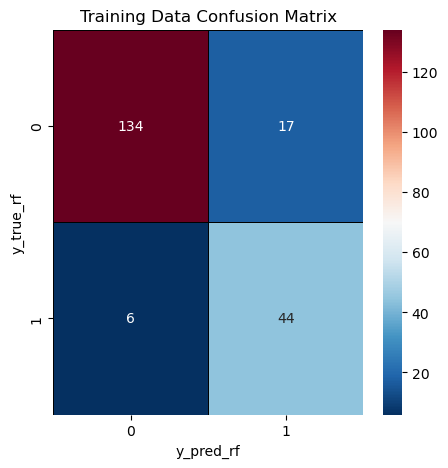

__________________________________________________
--------------------------------------------------
Results for: 0.35
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       151
           1       0.76      0.84      0.80        50

    accuracy                           0.90       201
   macro avg       0.85      0.88      0.86       201
weighted avg       0.90      0.90      0.90       201

Training Accuracy: 0.8955
Training Recall: 0.84


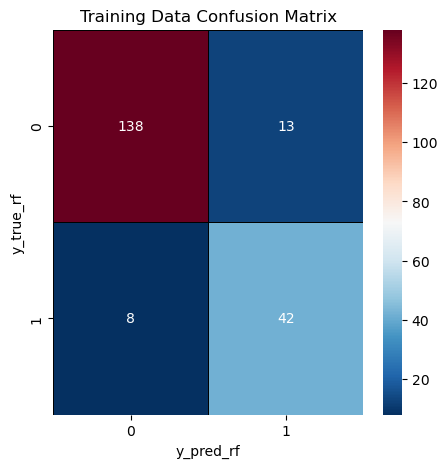

__________________________________________________
--------------------------------------------------
Results for: 0.4
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       151
           1       0.76      0.84      0.80        50

    accuracy                           0.90       201
   macro avg       0.85      0.88      0.86       201
weighted avg       0.90      0.90      0.90       201

Training Accuracy: 0.8955
Training Recall: 0.84


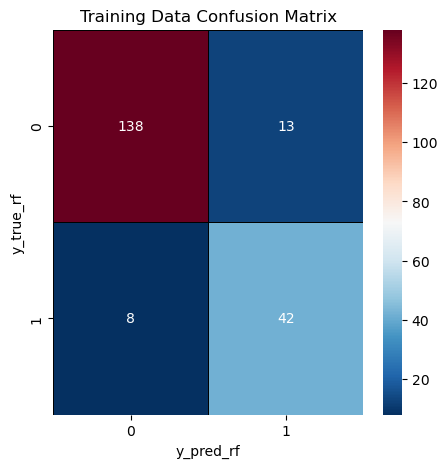

__________________________________________________
--------------------------------------------------
Results for: 0.45
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.83      0.76      0.79        50

    accuracy                           0.90       201
   macro avg       0.87      0.85      0.86       201
weighted avg       0.90      0.90      0.90       201

Training Accuracy: 0.9005
Training Recall: 0.76


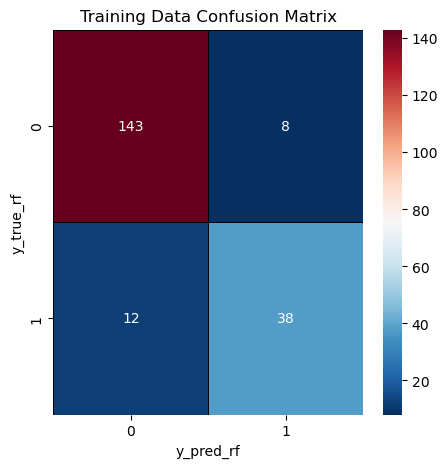

__________________________________________________
--------------------------------------------------
Results for: 0.5
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.83      0.76      0.79        50

    accuracy                           0.90       201
   macro avg       0.87      0.85      0.86       201
weighted avg       0.90      0.90      0.90       201

Training Accuracy: 0.9005
Training Recall: 0.76


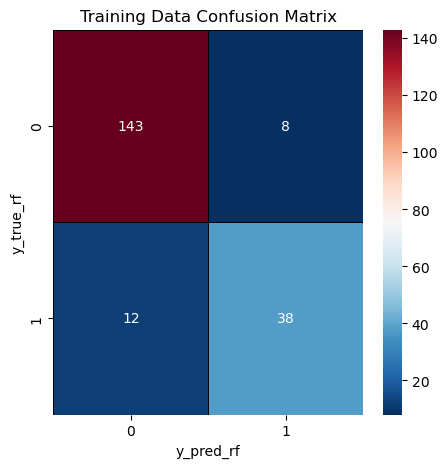

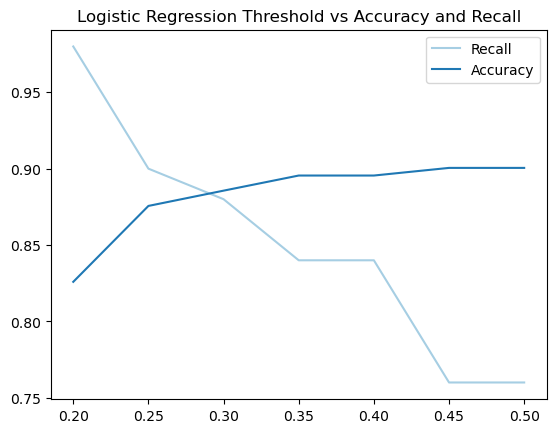

In [19]:
best_threshold(dtc_gscv_recall,train,y_train.iloc[:, -2])

Results for: DecisionTreeClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        38
           1       0.69      0.69      0.69        13

    accuracy                           0.84        51
   macro avg       0.79      0.79      0.79        51
weighted avg       0.84      0.84      0.84        51

Training Accuracy: 0.8431
Training Recall: 0.6923


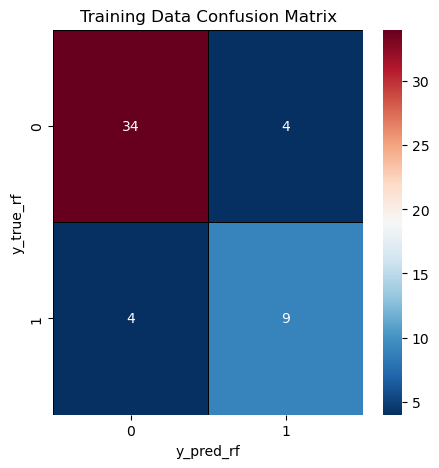

Results for: DecisionTreeClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        38
           1       0.89      0.62      0.73        13

    accuracy                           0.88        51
   macro avg       0.88      0.79      0.83        51
weighted avg       0.88      0.88      0.87        51

Training Accuracy: 0.8824
Training Recall: 0.6154


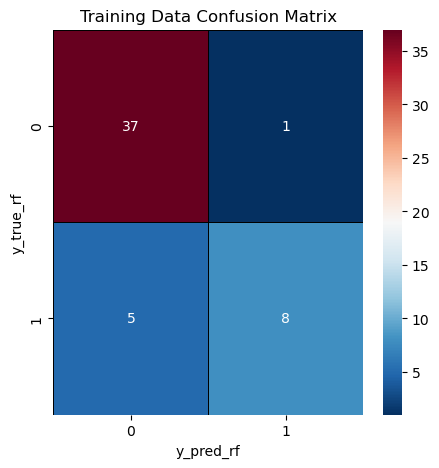

In [36]:
my_thresh = 0.25

y_pred_test_thresh = (dtc_gscv_recall.predict_proba(test)[:,1] >= my_thresh).astype(bool)
y_pred = dtc_gscv_recall.predict(test)

final_log=classification_results(test,y_test["mortalité à un an"],y_pred_test_thresh,dtc_gscv_recall, title="DecisionTreeClassifier Accuracy Optimized Model")
final_log=classification_results(test,y_test["mortalité à un an"],y_pred,dtc_gscv_recall, title="DecisionTreeClassifier Accuracy Optimized Model")


The result with decision tree classifier gives us a percentage of 86% on test data aftertunning the model
We cannot ameliorate the model any further.


We have ovefitting of the model

# RandomForestClassifier

__________________________________________________
--------------------------------------------------
Results for: RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


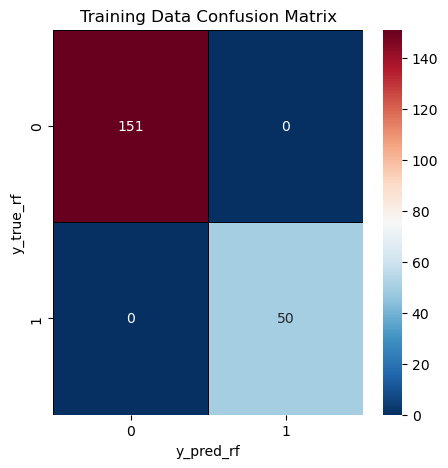

,RandomForestClassifier
0,1.0


In [196]:
showResult([RandomForestClassifier],train,y_train["mortalité à un an"])

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        38
           1       0.88      0.54      0.67        13

    accuracy                           0.86        51
   macro avg       0.87      0.76      0.79        51
weighted avg       0.86      0.86      0.85        51

Test Accuracy: 86.27%


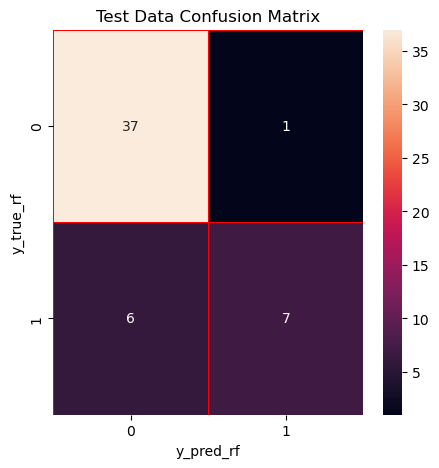

,RandomForestClassifier
0,0.8627


In [44]:
showResult([RandomForestClassifier],train,y_train["mortalité à un an"],test=[test,y_test["mortalité à un an"]])

In [24]:
rdf_param = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}


# Create a Decision Tree Classifier
clf = RandomForestClassifier()

RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_split=5,
                       n_estimators=150)
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.8298330681325178
Method
RandomForestClassifier
Results for Accuracy Optimized RandomForestClassifier GSCV
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       151
           1       0.92      0.48      0.63        50

    accuracy                           0.86       201
   macro avg       0.89      0.73      0.77       201
weighted avg       0.87      0.86      0.84       201

Training Accuracy: 0.8607
Training Recall: 0.48


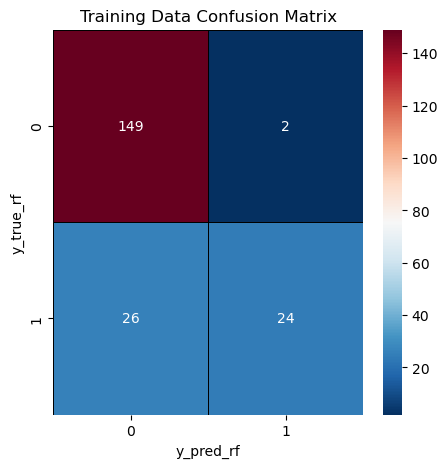

**************************************************
RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=150)
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.7501703732024559
Method
RandomForestClassifier
Results for Accuracy Optimized RandomForestClassifier GSCV
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       151
           1       0.89      0.48      0.62        50

    accuracy                           0.86       201
   macro avg       0.87      0.73      0.77       201
weighted avg       0.86      0.86      0.84       201

Training Accuracy: 0.8557
Training Recall: 0.48


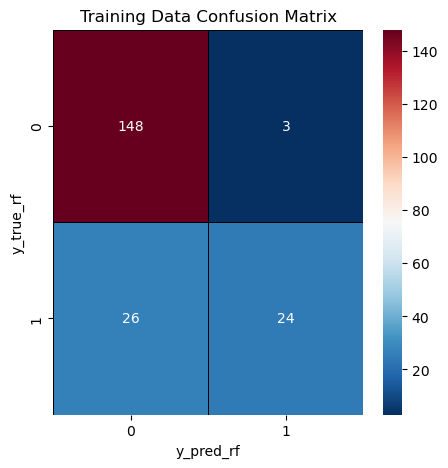

**************************************************
RandomForestClassifier(max_depth=5, min_samples_split=5)
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.8508536585365855
Method
RandomForestClassifier
Results for Accuracy Optimized RandomForestClassifier GSCV
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       151
           1       0.89      0.48      0.62        50

    accuracy                           0.86       201
   macro avg       0.87      0.73      0.77       201
weighted avg       0.86      0.86      0.84       201

Training Accuracy: 0.8557
Training Recall: 0.48


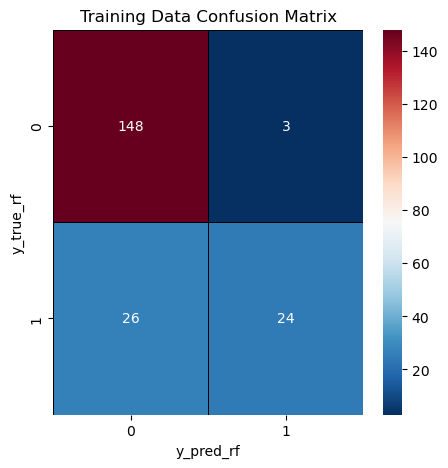

**************************************************
RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_split=5)
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.8508536585365853
Method
RandomForestClassifier
Results for Accuracy Optimized RandomForestClassifier GSCV
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       151
           1       0.89      0.48      0.62        50

    accuracy                           0.86       201
   macro avg       0.87      0.73      0.77       201
weighted avg       0.86      0.86      0.84       201

Training Accuracy: 0.8557
Training Recall: 0.48


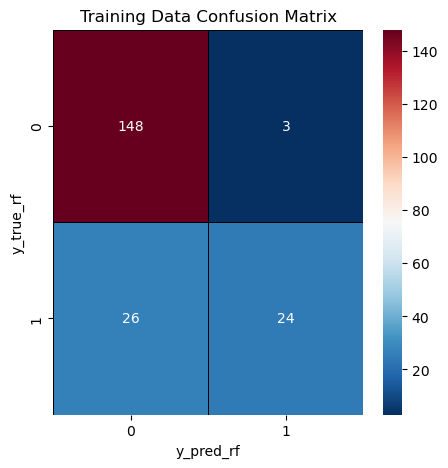

**************************************************
RandomForestClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_split=5, n_estimators=50)
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Score: 0.5
Method
RandomForestClassifier
Results for Accuracy Optimized RandomForestClassifier GSCV
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       151
           1       0.93      0.78      0.85        50

    accuracy                           0.93       201
   macro avg       0.93      0.88      0.90       201
weighted avg       0.93      0.93      0.93       201

Training Accuracy: 0.9303
Training Recall: 0.78


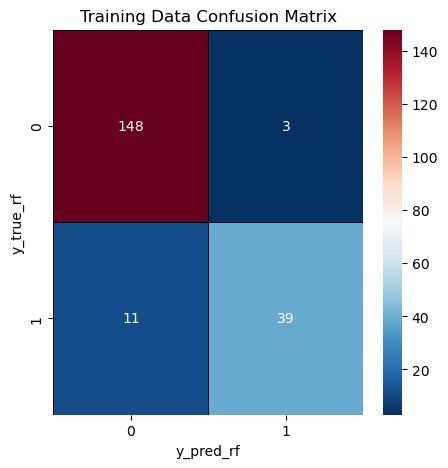

In [25]:
rfc_gscv_weighted,y_pred_weighted=modelTunning(rdf_param,train,y_train["mortalité à un an"],clf,scoring='f1_weighted')
print("*"*50)
rfc_gscv_macro,y_pred_macro=modelTunning(rdf_param,train,y_train["mortalité à un an"],clf,scoring='f1_macro')
print("*"*50)
rfc_gscv_micro,y_pred_micro=modelTunning(rdf_param,train,y_train["mortalité à un an"],clf,scoring='f1_micro')
print("*"*50)
rfc_gscv_accuracy,y_pred_accuracy=modelTunning(rdf_param,train,y_train["mortalité à un an"],clf,scoring='accuracy')
print("*"*50)
rfc_gscv_recall,y_pred_recall=modelTunning(rdf_param,train,y_train["mortalité à un an"],clf,scoring='recall')

The best parameters we are going to use for the analysis is recall because it gives a trainning accuracy of 0.9303 with the following parameters:

RandomForestClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_split=5, n_estimators=50)
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

__________________________________________________
--------------------------------------------------
Results for: 0.2
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       151
           1       0.69      1.00      0.82        50

    accuracy                           0.89       201
   macro avg       0.85      0.93      0.87       201
weighted avg       0.92      0.89      0.90       201

Training Accuracy: 0.8905
Training Recall: 1.0


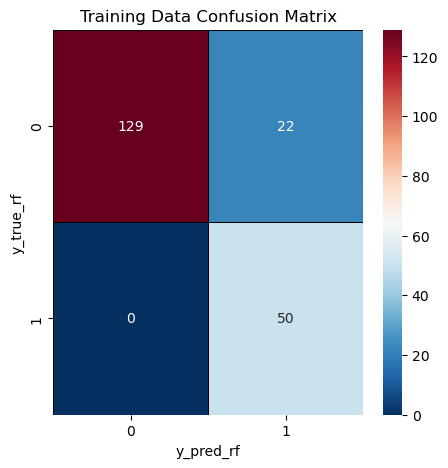

__________________________________________________
--------------------------------------------------
Results for: 0.25
              precision    recall  f1-score   support

           0       1.00      0.91      0.96       151
           1       0.79      1.00      0.88        50

    accuracy                           0.94       201
   macro avg       0.90      0.96      0.92       201
weighted avg       0.95      0.94      0.94       201

Training Accuracy: 0.9353
Training Recall: 1.0


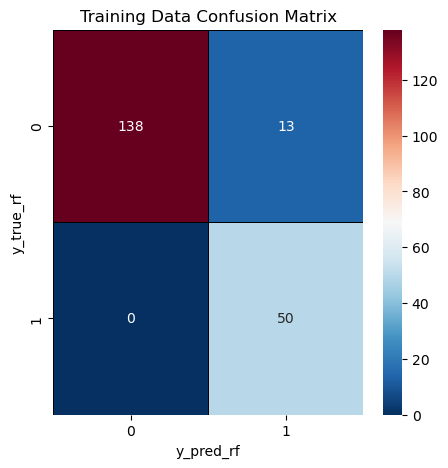

__________________________________________________
--------------------------------------------------
Results for: 0.3
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       151
           1       0.93      1.00      0.96        50

    accuracy                           0.98       201
   macro avg       0.96      0.99      0.97       201
weighted avg       0.98      0.98      0.98       201

Training Accuracy: 0.9801
Training Recall: 1.0


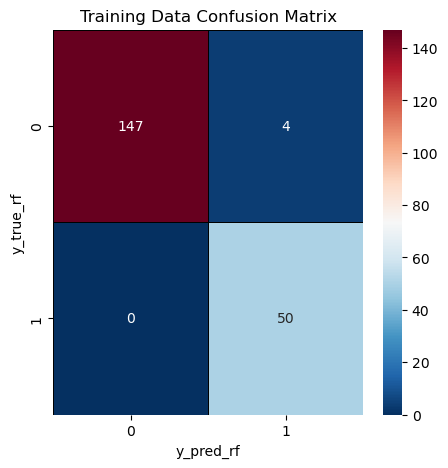

__________________________________________________
--------------------------------------------------
Results for: 0.35
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       151
           1       0.94      1.00      0.97        50

    accuracy                           0.99       201
   macro avg       0.97      0.99      0.98       201
weighted avg       0.99      0.99      0.99       201

Training Accuracy: 0.9851
Training Recall: 1.0


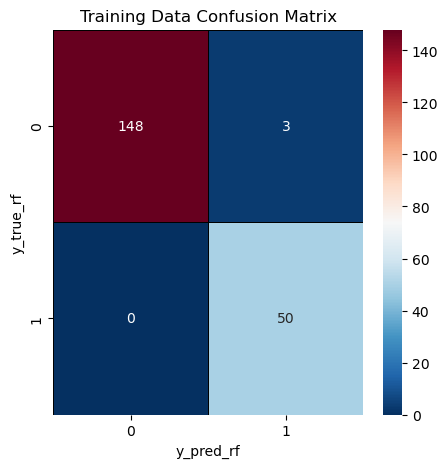

__________________________________________________
--------------------------------------------------
Results for: 0.4
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       151
           1       0.94      0.98      0.96        50

    accuracy                           0.98       201
   macro avg       0.97      0.98      0.97       201
weighted avg       0.98      0.98      0.98       201

Training Accuracy: 0.9801
Training Recall: 0.98


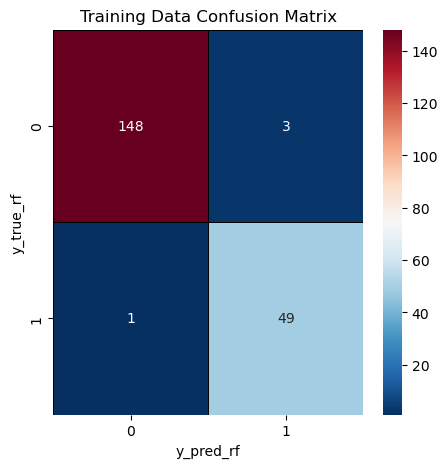

__________________________________________________
--------------------------------------------------
Results for: 0.45
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       151
           1       0.94      0.94      0.94        50

    accuracy                           0.97       201
   macro avg       0.96      0.96      0.96       201
weighted avg       0.97      0.97      0.97       201

Training Accuracy: 0.9701
Training Recall: 0.94


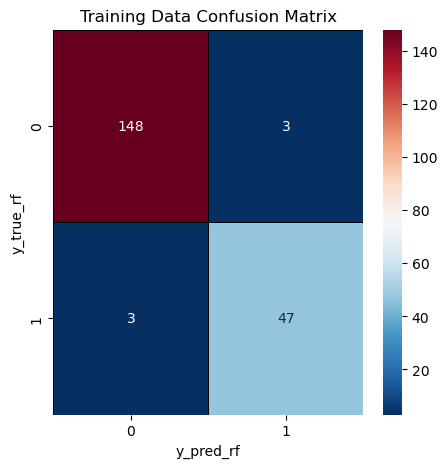

__________________________________________________
--------------------------------------------------
Results for: 0.5
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       151
           1       0.93      0.78      0.85        50

    accuracy                           0.93       201
   macro avg       0.93      0.88      0.90       201
weighted avg       0.93      0.93      0.93       201

Training Accuracy: 0.9303
Training Recall: 0.78


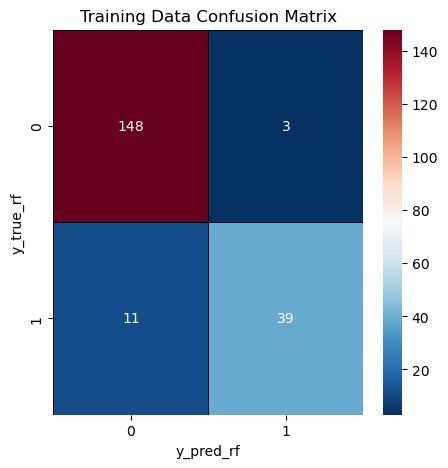

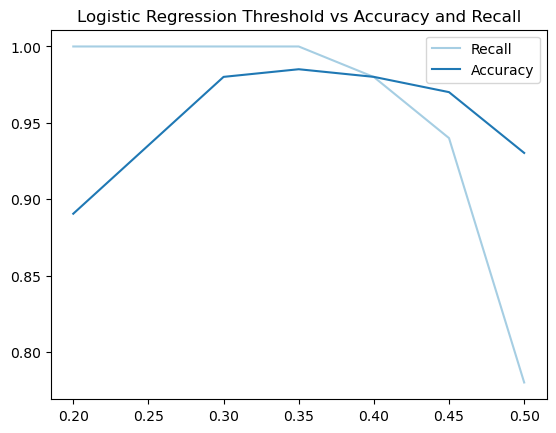

In [26]:
best_threshold(rfc_gscv_recall,train,y_train.iloc[:, -2])

Results for: RandomForestclassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        38
           1       0.80      0.62      0.70        13

    accuracy                           0.86        51
   macro avg       0.84      0.78      0.80        51
weighted avg       0.86      0.86      0.86        51

Training Accuracy: 0.8627
Training Recall: 0.6154


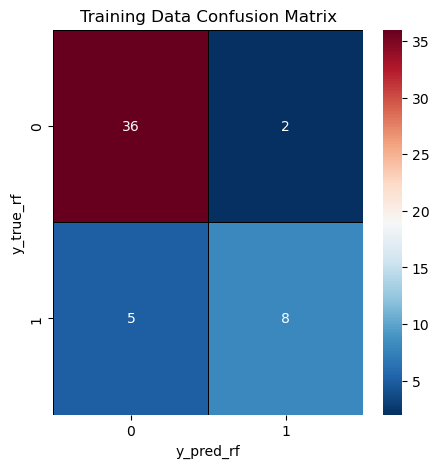

Results for: RandomForestclassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        38
           1       0.89      0.62      0.73        13

    accuracy                           0.88        51
   macro avg       0.88      0.79      0.83        51
weighted avg       0.88      0.88      0.87        51

Training Accuracy: 0.8824
Training Recall: 0.6154


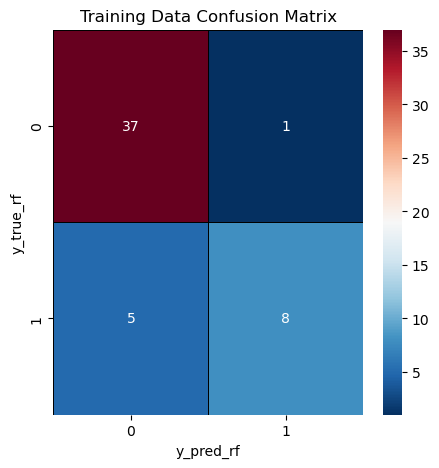

In [48]:
my_thresh = 0.35

y_pred_test_thresh = (rfc_gscv_recall.predict_proba(test)[:,1] >= my_thresh).astype(bool)
y_pred = dtc_gscv_recall.predict(test)

final_log=classification_results(test,y_test["mortalité à un an"],y_pred_test_thresh,rfc_gscv_recall, title="RandomForestclassifier Accuracy Optimized Model")
final_log=classification_results(test,y_test["mortalité à un an"],y_pred,rfc_gscv_recall, title="RandomForestclassifier Accuracy Optimized Model")


No amelioration on the performance of the model after tunning when we want to use threshold to find a balance between accuracy and recall. But our data set is imbalanced, we choose the best accuracy for our model having a high f1 score and a high accuracy. 
Then we obtain an accuracy of 88%

# KNeighborsClassifier

__________________________________________________
--------------------------------------------------
Results for: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       151
           1       0.82      0.36      0.50        50

    accuracy                           0.82       201
   macro avg       0.82      0.67      0.70       201
weighted avg       0.82      0.82      0.79       201

Training Accuracy: 0.8209
Training Recall: 0.36


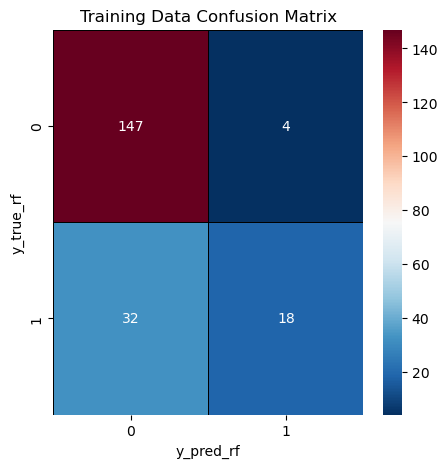

,KNeighborsClassifier
0,0.8209


In [145]:
showResult([KNeighborsClassifier],train,y_train["mortalité à un an"])

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        38
           1       0.86      0.46      0.60        13

    accuracy                           0.84        51
   macro avg       0.85      0.72      0.75        51
weighted avg       0.85      0.84      0.83        51

Test Accuracy: 84.31%


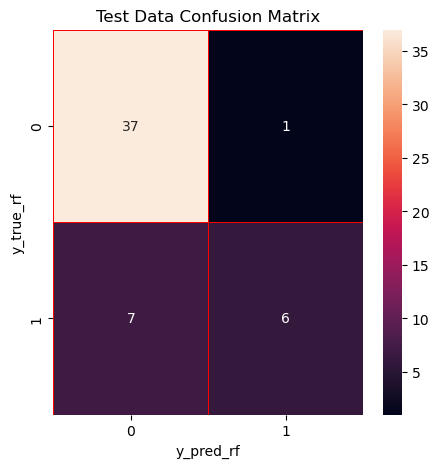

,KNeighborsClassifier
0,0.8431


In [146]:
showResult([KNeighborsClassifier],train,y_train["mortalité à un an"],test=[test,y_test["mortalité à un an"]])

In [147]:
knn_param = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 20, 30, 40],  # Additional parameter: leaf_size
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Additional parameter: algorithm
}
cls = KNeighborsClassifier()

KNeighborsClassifier(leaf_size=10, n_neighbors=3, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.745804938118478
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


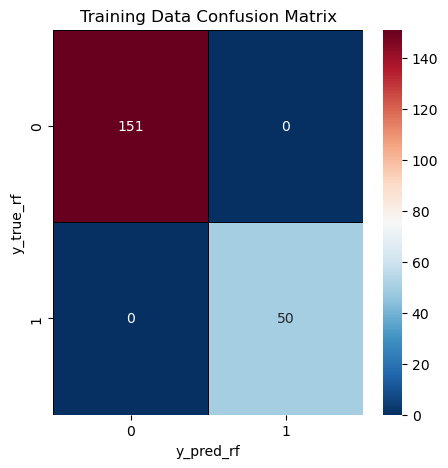

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.6374875305165034
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


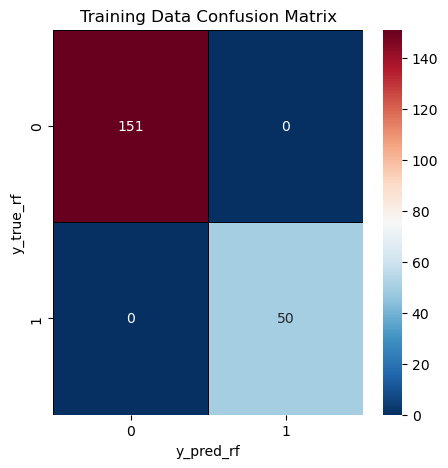

**************************************************
KNeighborsClassifier(leaf_size=10, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'distance'}
Best Score: 0.7713414634146342
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


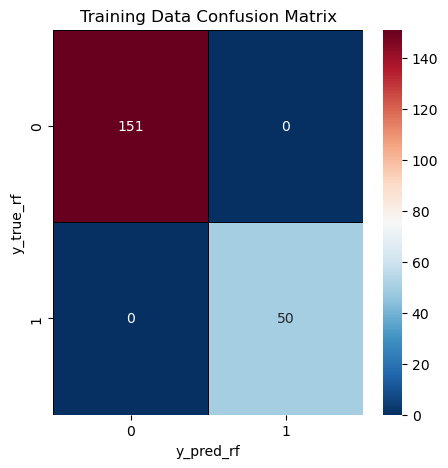

**************************************************
KNeighborsClassifier(leaf_size=10, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'distance'}
Best Score: 0.7713414634146342
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


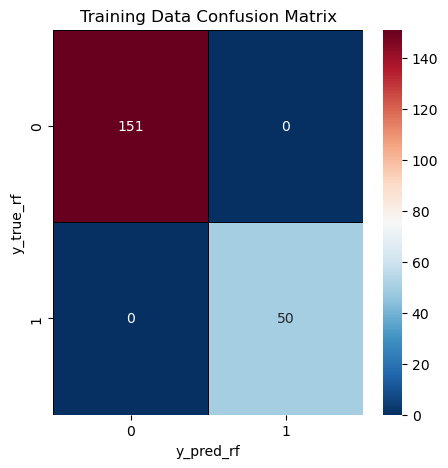

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.36
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


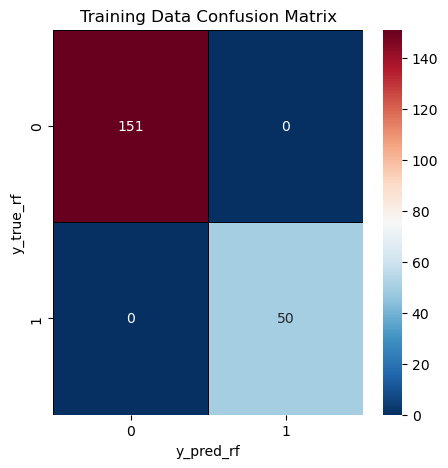

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.42224089635854345
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


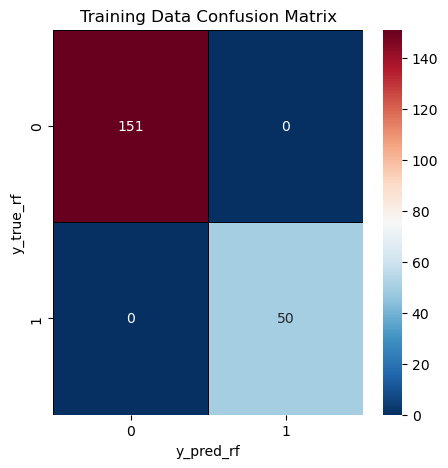

In [148]:
knn_gscv_weighted,y_pred_weighted=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_weighted')
print("*"*50)
knn_gscv_macro,y_pred_macro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_macro')
print("*"*50)
knn_gscv_micro,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_micro')
print("*"*50)
knn_gscv_accuracy,y_pred_accuracy=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='accuracy')
print("*"*50)
knn_gscv_recall,y_pred_recall=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='recall')
print("*"*50)
knn_gscv_f,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1')

In [117]:
knn_param = { 
    'n_neighbors':[ 5],
    'weights': ['uniform'],
    'algorithm': ['auto'],
    'leaf_size': [30],
    'p': [2] 
}

In [152]:
#Avoiding overfitting
knn_param = {'n_neighbors': [3, 5],
              'weights': ['uniform'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10,20,30, 40, 50],
              'p': [1,2]}

KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.7515352433379394
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


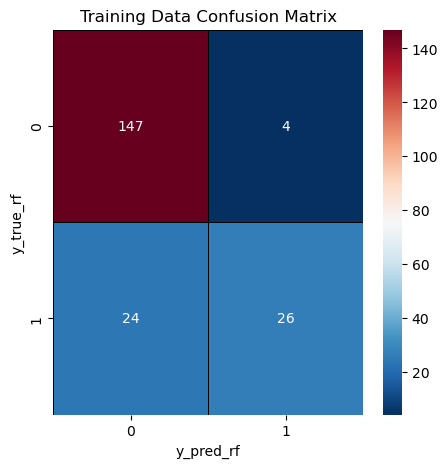

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.640518824078345
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


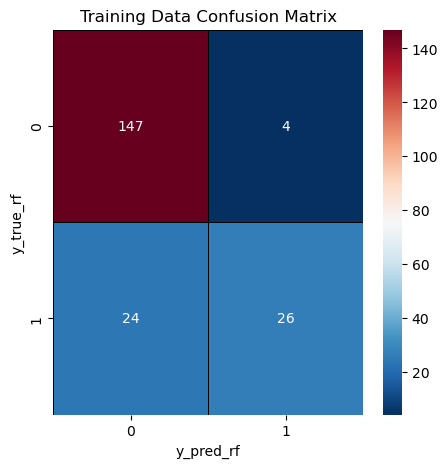

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.7764634146341465
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


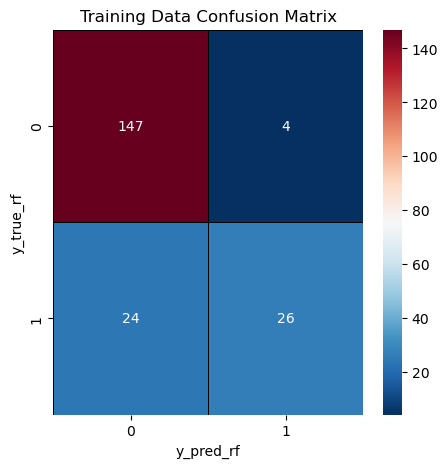

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.7764634146341464
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


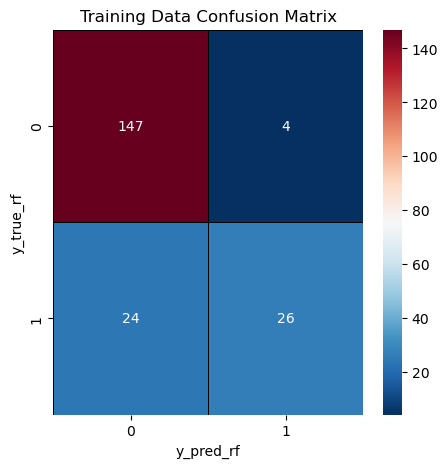

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.34
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


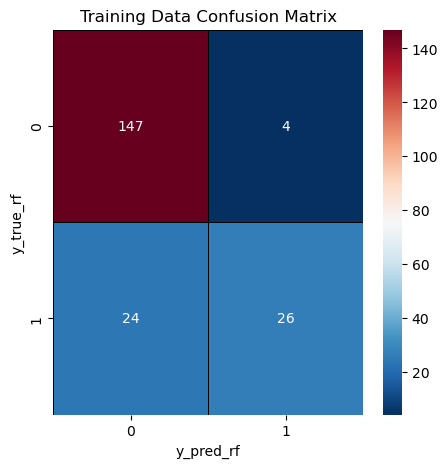

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.4198717948717949
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


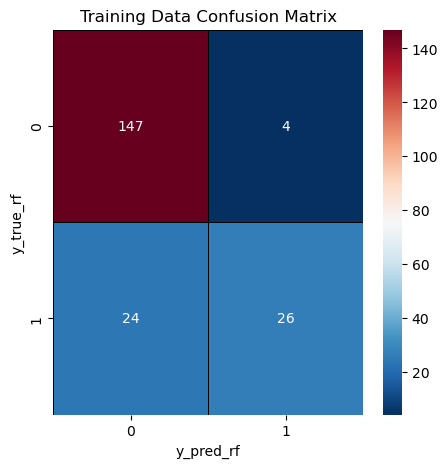

In [153]:
knn_gscv_weighted,y_pred_weighted=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_weighted')
print("*"*50)
knn_gscv_macro,y_pred_macro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_macro')
print("*"*50)
knn_gscv_micro,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_micro')
print("*"*50)
knn_gscv_accuracy,y_pred_accuracy=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='accuracy')
print("*"*50)
knn_gscv_recall,y_pred_recall=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='recall')
print("*"*50)
knn_gscv_f,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1')

__________________________________________________
--------------------------------------------------
Results for: 0.2
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       151
           1       0.47      1.00      0.64        50

    accuracy                           0.72       201
   macro avg       0.74      0.81      0.71       201
weighted avg       0.87      0.72      0.74       201

Training Accuracy: 0.7214
Training Recall: 1.0


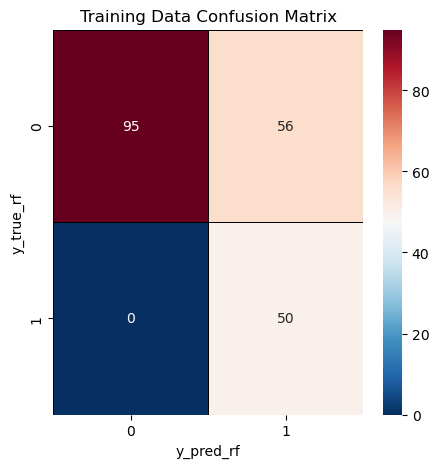

__________________________________________________
--------------------------------------------------
Results for: 0.25
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       151
           1       0.47      1.00      0.64        50

    accuracy                           0.72       201
   macro avg       0.74      0.81      0.71       201
weighted avg       0.87      0.72      0.74       201

Training Accuracy: 0.7214
Training Recall: 1.0


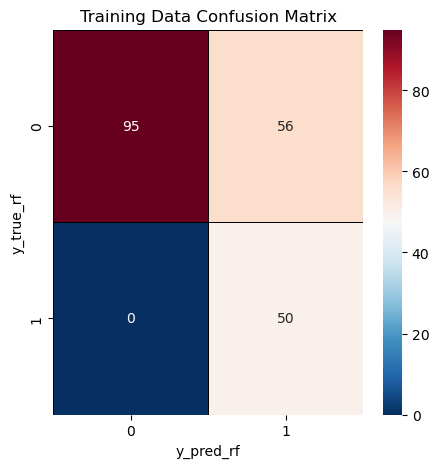

__________________________________________________
--------------------------------------------------
Results for: 0.3
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       151
           1       0.47      1.00      0.64        50

    accuracy                           0.72       201
   macro avg       0.74      0.81      0.71       201
weighted avg       0.87      0.72      0.74       201

Training Accuracy: 0.7214
Training Recall: 1.0


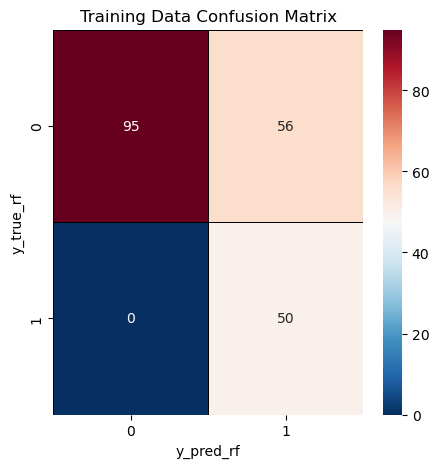

__________________________________________________
--------------------------------------------------
Results for: 0.35
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


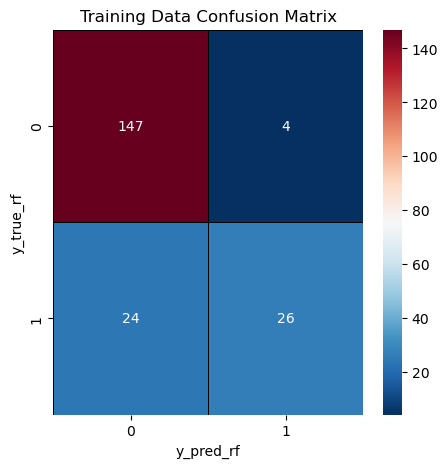

__________________________________________________
--------------------------------------------------
Results for: 0.4
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


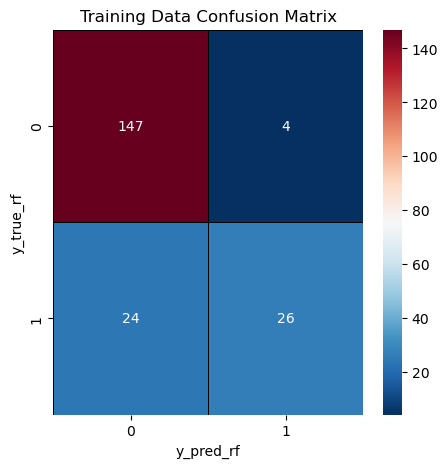

__________________________________________________
--------------------------------------------------
Results for: 0.45
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


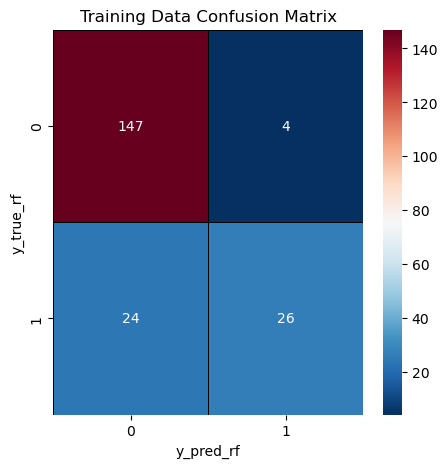

__________________________________________________
--------------------------------------------------
Results for: 0.5
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


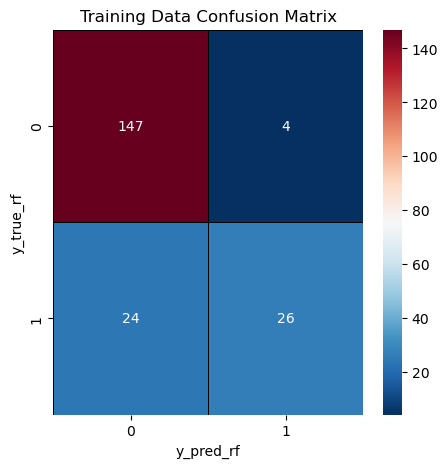

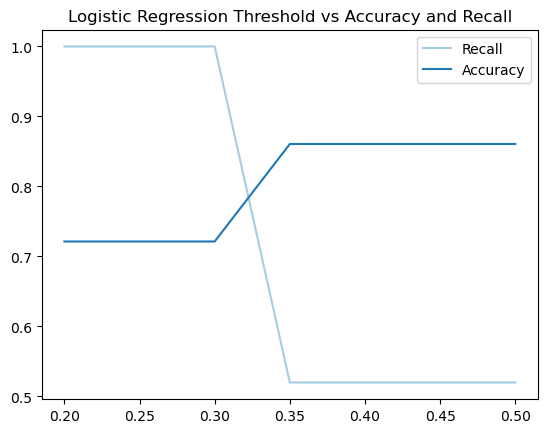

In [154]:
best_threshold(knn_gscv_f,train,y_train.iloc[:, -2])

Results for: KNeighborsClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        38
           1       0.45      0.69      0.55        13

    accuracy                           0.71        51
   macro avg       0.66      0.70      0.66        51
weighted avg       0.76      0.71      0.72        51

Training Accuracy: 0.7059
Training Recall: 0.6923


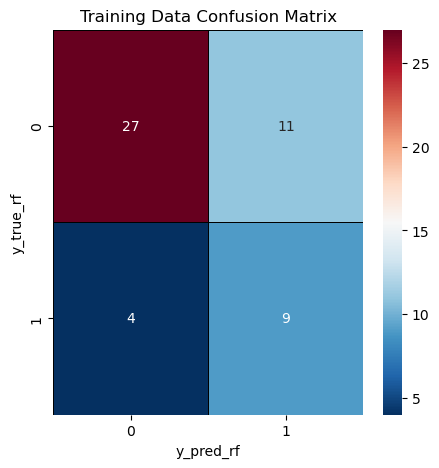

Results for: KNeighborsClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        38
           1       0.67      0.46      0.55        13

    accuracy                           0.80        51
   macro avg       0.75      0.69      0.71        51
weighted avg       0.79      0.80      0.79        51

Training Accuracy: 0.8039
Training Recall: 0.4615


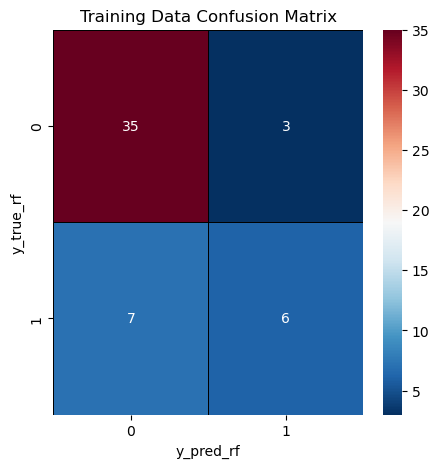

In [156]:
my_thresh = 0.32

y_pred_test_thresh = (knn_gscv_accuracy.predict_proba(test)[:,1] >= my_thresh).astype(bool)
y_pred = knn_gscv_accuracy.predict(test)

final_log=classification_results(test,y_test["mortalité à un an"],y_pred_test_thresh,knn_gscv_f, title="KNeighborsClassifier Accuracy Optimized Model")
final_log=classification_results(test,y_test["mortalité à un an"],y_pred,knn_gscv_f, title="KNeighborsClassifier Accuracy Optimized Model")


WHEN USING TAELCORE with our data set, it is very difficult to tune the model and get a better accurancy. With certain models, the process of tunning overfit, like with knn, and during testing the model works poorly.

In [188]:
knn_param = { 
    'n_neighbors':[ 3,5],
    'weights': ['uniform'],
    'algorithm': ['auto'],
    'leaf_size': [30],
    'p': [2] 
}

KNeighborsClassifier(n_neighbors=3)
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Score: 0.7265614259907155
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       151
           1       0.87      0.54      0.67        50

    accuracy                           0.87       201
   macro avg       0.87      0.76      0.79       201
weighted avg       0.87      0.87      0.85       201

Training Accuracy: 0.8657
Training Recall: 0.54


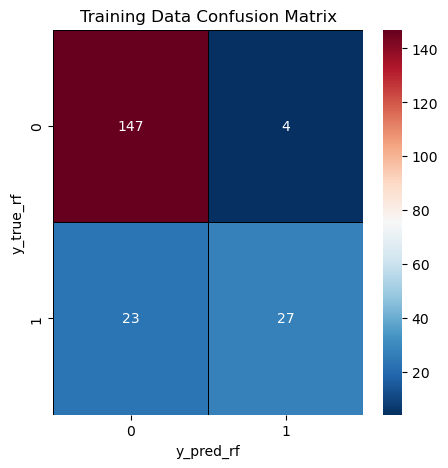

**************************************************
KNeighborsClassifier(n_neighbors=3)
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Score: 0.6022184352853588
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       151
           1       0.87      0.54      0.67        50

    accuracy                           0.87       201
   macro avg       0.87      0.76      0.79       201
weighted avg       0.87      0.87      0.85       201

Training Accuracy: 0.8657
Training Recall: 0.54


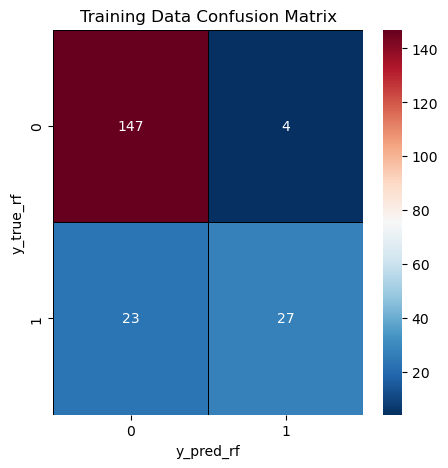

**************************************************
KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best Score: 0.7565853658536587
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       151
           1       0.82      0.36      0.50        50

    accuracy                           0.82       201
   macro avg       0.82      0.67      0.70       201
weighted avg       0.82      0.82      0.79       201

Training Accuracy: 0.8209
Training Recall: 0.36


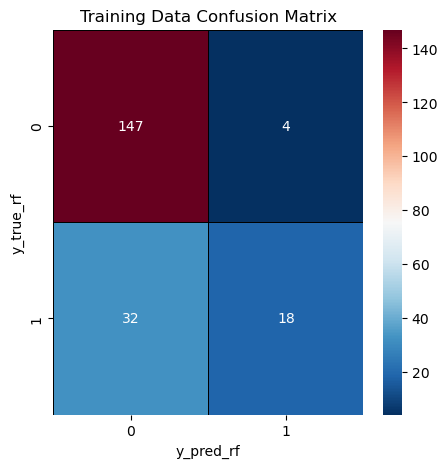

**************************************************
KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best Score: 0.7565853658536585
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       151
           1       0.82      0.36      0.50        50

    accuracy                           0.82       201
   macro avg       0.82      0.67      0.70       201
weighted avg       0.82      0.82      0.79       201

Training Accuracy: 0.8209
Training Recall: 0.36


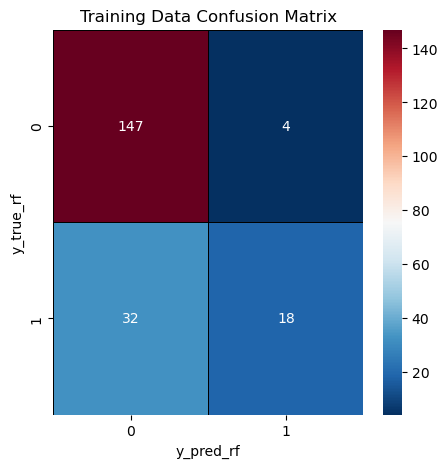

**************************************************
KNeighborsClassifier(n_neighbors=3)
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Score: 0.28
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       151
           1       0.87      0.54      0.67        50

    accuracy                           0.87       201
   macro avg       0.87      0.76      0.79       201
weighted avg       0.87      0.87      0.85       201

Training Accuracy: 0.8657
Training Recall: 0.54


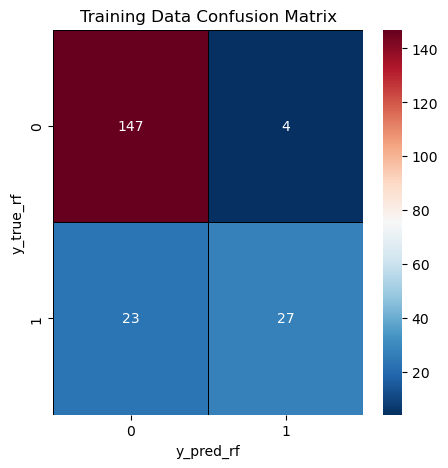

**************************************************
KNeighborsClassifier(n_neighbors=3)
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Score: 0.35492063492063497
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       151
           1       0.87      0.54      0.67        50

    accuracy                           0.87       201
   macro avg       0.87      0.76      0.79       201
weighted avg       0.87      0.87      0.85       201

Training Accuracy: 0.8657
Training Recall: 0.54


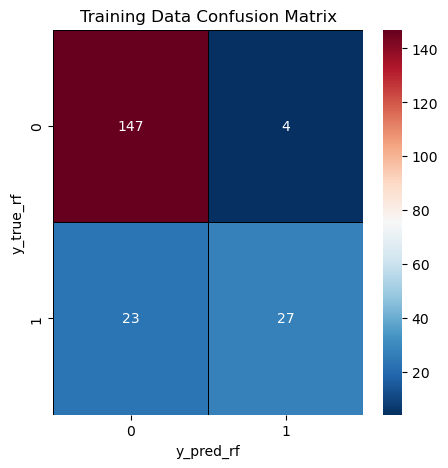

In [189]:
knn_gscv_weighted,y_pred_weighted=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_weighted')
print("*"*50)
knn_gscv_macro,y_pred_macro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_macro')
print("*"*50)
knn_gscv_micro,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_micro')
print("*"*50)
knn_gscv_accuracy,y_pred_accuracy=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='accuracy')
print("*"*50)
knn_gscv_recall,y_pred_recall=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='recall')
print("*"*50)
knn_gscv_f,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1')

In [167]:
#best_threshold(knn_gscv_accuracy,train,y_train.iloc[:, -2])

Results for: KNeighborsClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        38
           1       0.86      0.46      0.60        13

    accuracy                           0.84        51
   macro avg       0.85      0.72      0.75        51
weighted avg       0.85      0.84      0.83        51

Training Accuracy: 0.8431
Training Recall: 0.4615


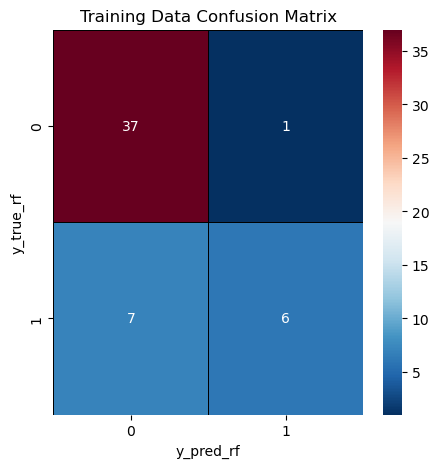

In [193]:
#my_thresh = 0.25

#y_pred_test_thresh = (knn_gscv_accuracy.predict_proba(test)[:,1] >= my_thresh).astype(bool)
y_pred = knn_gscv_accuracy.predict(test)

#final_log=classification_results(test,y_test["mortalité à un an"],y_pred_test_thresh,knn_gscv_f, title="KNeighborsClassifier Accuracy Optimized Model")
final_log=classification_results(test,y_test["mortalité à un an"],y_pred,knn_gscv_accuracy, title="KNeighborsClassifier Accuracy Optimized Model")


Results for: KNeighborsClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        38
           1       0.67      0.46      0.55        13

    accuracy                           0.80        51
   macro avg       0.75      0.69      0.71        51
weighted avg       0.79      0.80      0.79        51

Training Accuracy: 0.8039
Training Recall: 0.4615


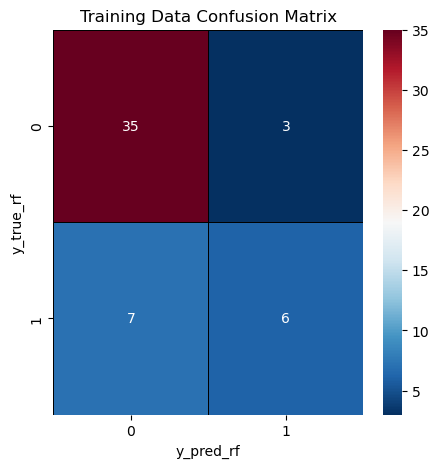

In [194]:
#my_thresh = 0.25

#y_pred_test_thresh = (knn_gscv_accuracy.predict_proba(test)[:,1] >= my_thresh).astype(bool)
y_pred = knn_gscv_recall.predict(test)

#final_log=classification_results(test,y_test["mortalité à un an"],y_pred_test_thresh,knn_gscv_f, title="KNeighborsClassifier Accuracy Optimized Model")
final_log=classification_results(test,y_test["mortalité à un an"],y_pred,knn_gscv_recall, title="KNeighborsClassifier Accuracy Optimized Model")


In [ ]:
#taelcore + machine

Ian Morilla
12:59 PM
PCA + machine

Ia
Ian Morilla
12:59 PM
Taelcore + machine

Ia
Ian Morilla
12:59 PM
PCA + TDA + machine

Ia
Ian Morilla
1:00 PM
PCA + TDA + reinforcement

Ia
Ian Morilla
1:01 PM
PCA + TDA + reinforcement comparer avec Taelcore + machine

# Randomforest is the best model with accuracy of 88%